# Statistical Modeling of PhIP-seq Data

The alignments were manually generated with this command:

```
bowtie2 -L 30 -N 3 -p 3 --norc --no-hd \
    -x ~/repos/phage_libraries_private/human90/indexes/bowtie2/human90 \
    -U Sjogrens.serum.Sjogrens.FS10-01971.20A20G.1_R1.fq \
    > Sjogrens.bowtie2.aln
```

Counts were generated like so

```
phip compute-counts -i . -o counts -r ~/repos/phage_libraries_private/human90/inputs/human90-larman1-input.tsv
mv counts/Sjogrens.bowtie2.tsv .
rmdir counts
```

In [1]:
%matplotlib inline

In [24]:
import numpy as np
import scipy as sp
import scipy.stats
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
results = pd.read_csv('../examples/Sjogrens.bowtie2.tsv', sep='\t', header=0)
results['pep_id'] = results['id'].str.split('|').str[0]
results.rename(columns={'Sjogrens.bowtie2': 'output'}, inplace=True)
beadsonly = pd.read_csv('../examples/PhIP6_90mer_BeadsOnly.txt', sep='\t', header=0)
beadsonly.rename(columns={'INPUT_RC': 'beadsonly'}, inplace=True)
merged = pd.merge(results, beadsonly, how='left', left_on='pep_id', right_on='row_name')
counts = merged[['id', 'input', 'beadsonly', 'output']]

In [29]:
counts.head()

,id,input,beadsonly,output
0,hblOligo131399|NM_000014|2B,24,3,0
1,hblOligo131400|NM_000014|4B,137,21,5
2,hblOligo131401|NM_000014|6B,21,1,3
3,hblOligo131402|NM_000014|8B,253,33,9
4,hblOligo131403|NM_000014|10B,0,0,6


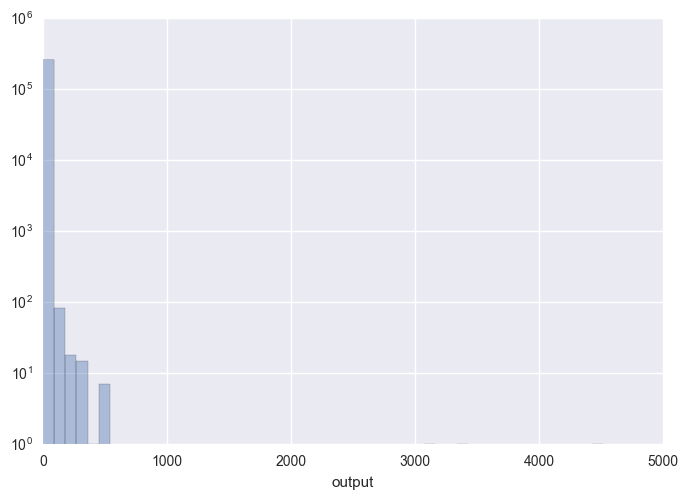

In [20]:
sns.distplot(counts['output'], kde=False, hist_kws={'log': True})

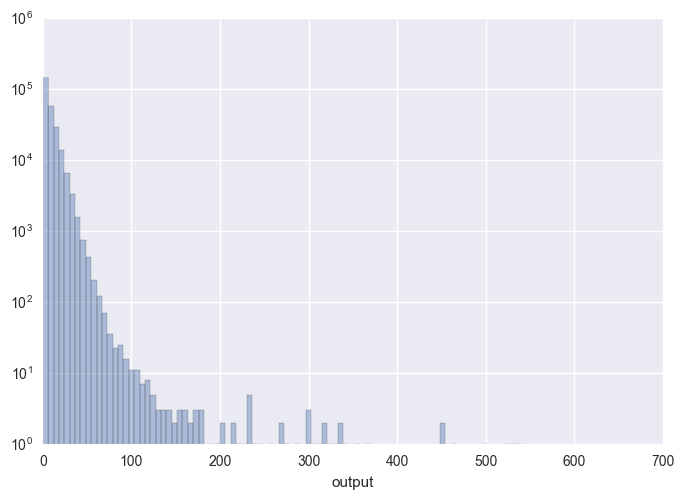

In [70]:
sns.distplot(counts['output'], bins=np.linspace(0, 600, 100), kde=False, hist_kws={'log': True})

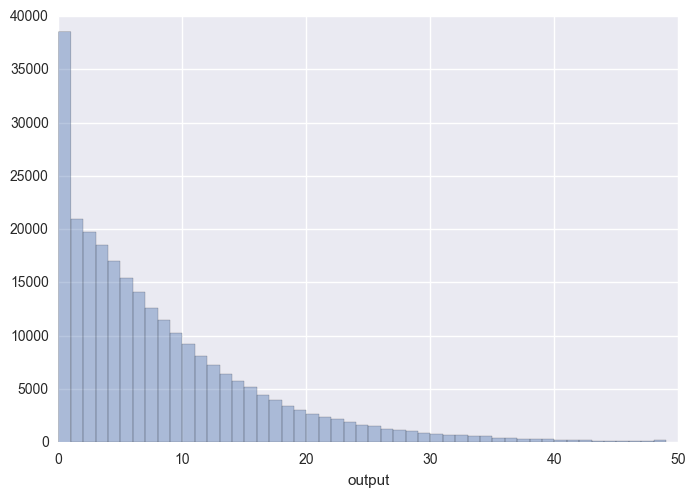

In [22]:
sns.distplot(counts['output'], bins=range(50), kde=False, hist_kws={'log': False})

In [55]:
sp.stats.scoreatpercentile(counts['output'], 90)

19.0

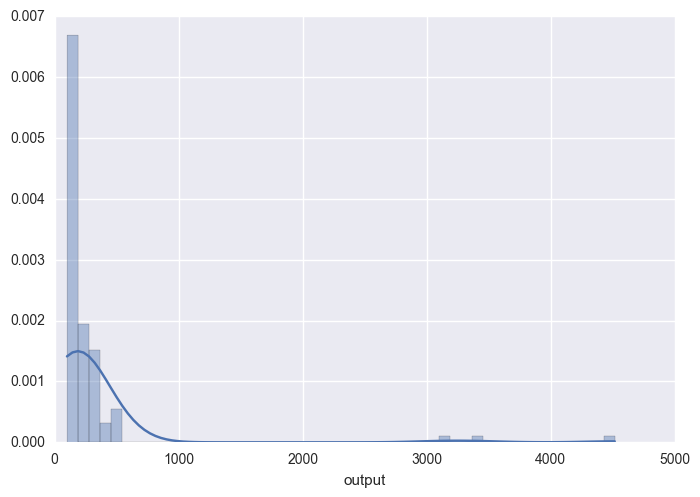

In [60]:
sns.distplot(counts['output'][counts['output'] > 100])

Determine bins for `input` and `beads_only`

In [71]:
input_upper_bound = sp.stats.scoreatpercentile(counts['input'], 90)
beadsonly_upper_bound = sp.stats.scoreatpercentile(counts['beadsonly'], 90)

In [72]:
counts['input_bin'] = pd.cut(counts['input'], np.linspace(0, input_upper_bound, 20), include_lowest=True)
counts['beadsonly_bin'] = pd.cut(counts['beadsonly'], np.linspace(0, beadsonly_upper_bound, 20), include_lowest=True)

In [73]:
grouped = counts.groupby(by=('input_bin', 'beadsonly_bin'), as_index=False)['output'].agg({'output_median': np.median, 'bin_count': len})

In [77]:
grouped[grouped['bin_count']>100].head()

,input_bin,beadsonly_bin,bin_count,output_median
0,"[0, 34.789]","[0, 4]",44664,1.0
1,"[0, 34.789]","(4, 8]",3727,2.0
2,"[0, 34.789]","(8, 12]",590,2.0
9,"(34.789, 69.579]","[0, 4]",9882,2.0
10,"(34.789, 69.579]","(4, 8]",9874,2.0


In [91]:
output_medians = pd.crosstab(counts['input_bin'], counts['beadsonly_bin'], values=counts['output'], aggfunc=np.median)
bin_counts = pd.crosstab(counts['input_bin'], counts['beadsonly_bin'])

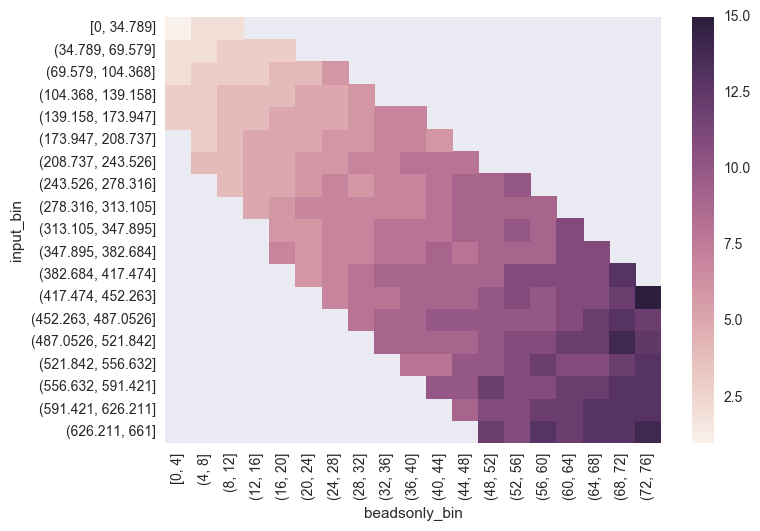

In [92]:
sns.heatmap(output_medians[bin_counts > 100])

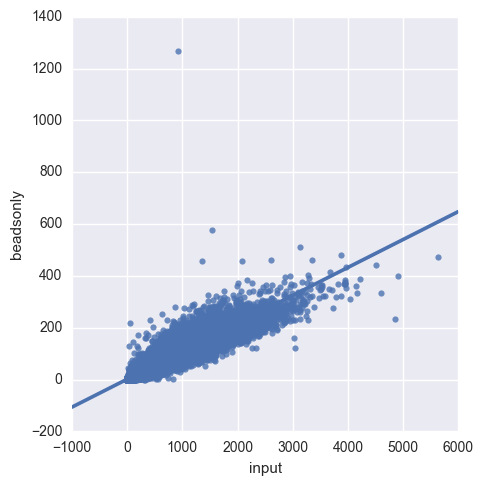

In [90]:
sns.lmplot('input', 'beadsonly', counts)

In [93]:
counts[counts['beadsonly']>600]

,id,input,beadsonly,output,input_bin,beadsonly_bin
33732,hblOligo82803|NM_001098623|17A,918,1269,32,NaN,NaN
